In [1]:
import pandas as pd

from qiime2 import Artifact

import seaborn as sns

import skbio
from skbio.stats.distance import MissingIDError
from skbio import DistanceMatrix

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import csv

import qiime2 as q2

In [2]:
#Load distance matrix
original_dm = Artifact.load('core-metrics-10000/unweighted_unifrac_distance_matrix.qza').view(DistanceMatrix)

/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ten

In [3]:
#load metadata
md = q2.Metadata.load('filtered-metadata.qza').to_dataframe()

In [4]:
#sync metadata to distance matrix

#remove samples in distance matrix that are not in metadata
original_dm = original_dm.filter(set(md.index) & set(original_dm.ids))

#remove samples in metadata that are not in distance matrix
md = md.loc[list(original_dm.ids)]

In [5]:
class MyDM(skbio.DistanceMatrix):
    def _stable_order(self, ids):

        id_order = sorted(self._id_index[i] for i in ids)
        return np.array(id_order, dtype=int)
    
    def between(self, from_, to_, allow_overlap=False):

        from_ = set(from_)
        to_ = set(to_)

        all_ids = from_ | to_
        not_present = all_ids - set(self._id_index)
        if not_present:
            raise MissingIDError("At least one ID (e.g., '%s') was not "
                                 "found." % not_present.pop())

        overlapping = from_ & to_
        if not allow_overlap and overlapping:
            raise KeyError("At least one ID overlaps in from_ and to_ "
                           "(e.g., '%s'). This constraint can removed with "
                           "allow_overlap=True." % overlapping.pop())

        return self._subset_to_dataframe(from_, to_)
    
    def _subset_to_dataframe(self, i_ids, j_ids):

        i_indices = self._stable_order(i_ids)
        j_indices = self._stable_order(j_ids)

        j_length = len(j_indices)
        j_labels = tuple([self.ids[j] for j in j_indices])

        i = []
        j = []

        values = [np.array([])]
        for i_idx in i_indices:
            i.extend([self.ids[i_idx]] * j_length)
            j.extend(j_labels)

            subset = self._data[i_idx, j_indices]
            values.append(subset)

        i = pd.Series(i, name='i')
        j = pd.Series(j, name='j')
        values = pd.Series(np.hstack(values), name='value')

        return pd.concat([i, j, values], axis=1)

In [6]:
def gather_between_distances(a_dm, a_md, fresh_baseline):
    pleasant_dm = MyDM(a_dm)

    tidy_data = []
    
    categories = ['sample_preservation_method', 'sample_storage_temp_treatment_week_added',
                  'duration_of_storage']
    
    if fresh_baseline:
        baseline_ids = {}
        for hid, grp in md.groupby('host_subject_id'):
            only_fresh = grp[grp['duration_of_storage'] == 'fresh']
            for preservative, pres_grp in only_fresh.groupby('sample_preservation_method'):
                baseline_ids[(hid, preservative)] = pres_grp.index
        
    else:
        baseline_ids = {}
        for hid, grp in a_md.groupby('host_subject_id'):
            host_baseline = []
            for index, row in grp[categories].iterrows():
                if (row == ['None', 'amb', 'fresh']).all():
                    host_baseline.append(index)
            baseline_ids[hid] = host_baseline
    
    for (pres, temp, dur, hid), grp in a_md.groupby(categories + ['host_subject_id']):   
        if fresh_baseline:
            if (hid,pres) in baseline_ids:
                base_ids = baseline_ids[hid,pres]
                
                distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)
                distances['sample_preservation_method'] = pres
                distances['sample_storage_temp_treatment_week_added'] = temp
                distances['duration_of_storage'] = dur

                tidy_data.append(distances)
        else:
            base_ids = baseline_ids[hid]
            
            distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)

            distances['sample_preservation_method'] = pres
            distances['sample_storage_temp_treatment_week_added'] = temp
            distances['duration_of_storage'] = dur

            tidy_data.append(distances)

    tidy_data = pd.concat(tidy_data)
    
    return tidy_data[tidy_data['i'] != tidy_data['j']]

In [7]:
categories = ['sample_preservation_method', 'sample_storage_temp_treatment_week_added',
              'duration_of_storage']

host_baseline = []

for hid, grp in md.groupby('host_subject_id'):
    for index, row in grp[categories].iterrows():
        if (row == ['None', 'amb', 'fresh']).all():
            host_baseline.append(index)
            
md_list = []

for i in host_baseline:
    md2 = md[md.index==i]
    md_list.append(md2)
    
md_df = pd.concat(md_list)

between_distances3 = gather_between_distances(original_dm, md_df, False)

between_distances3.loc[:,"value"].median()

0.2811379851582572

In [8]:
def fancy_plotting(df):
    g = sns.catplot(data=df, x='duration_of_storage', y='value', 
                    hue='sample_storage_temp_treatment_week_added', col='sample_preservation_method',
                    kind='box', col_wrap=3,
                    #palette=sns.color_palette("RdBu_r", 7)
                    order=['1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Duration of Storage", "Unweighted Unifrac Distance")
    g.set_xticklabels(["1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
    g._legend.set_title("Temperature Treatment")
    
    new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
        ax.axhline(0.7, ls='-', color='0.1', linewidth=2) #inter-species
        ax.axhline(0.55, ls='-', color='0.3', linewidth=2) #inter-human
        ax.axhline(0.5, ls='-', color='0.5', linewidth=2) #inter-dog
        
        ax.axhline(0.28, ls='-', color='0.5', linewidth=2) #inter-replicate
        
    return g

In [9]:
between_distances1 = gather_between_distances(original_dm, md, True)

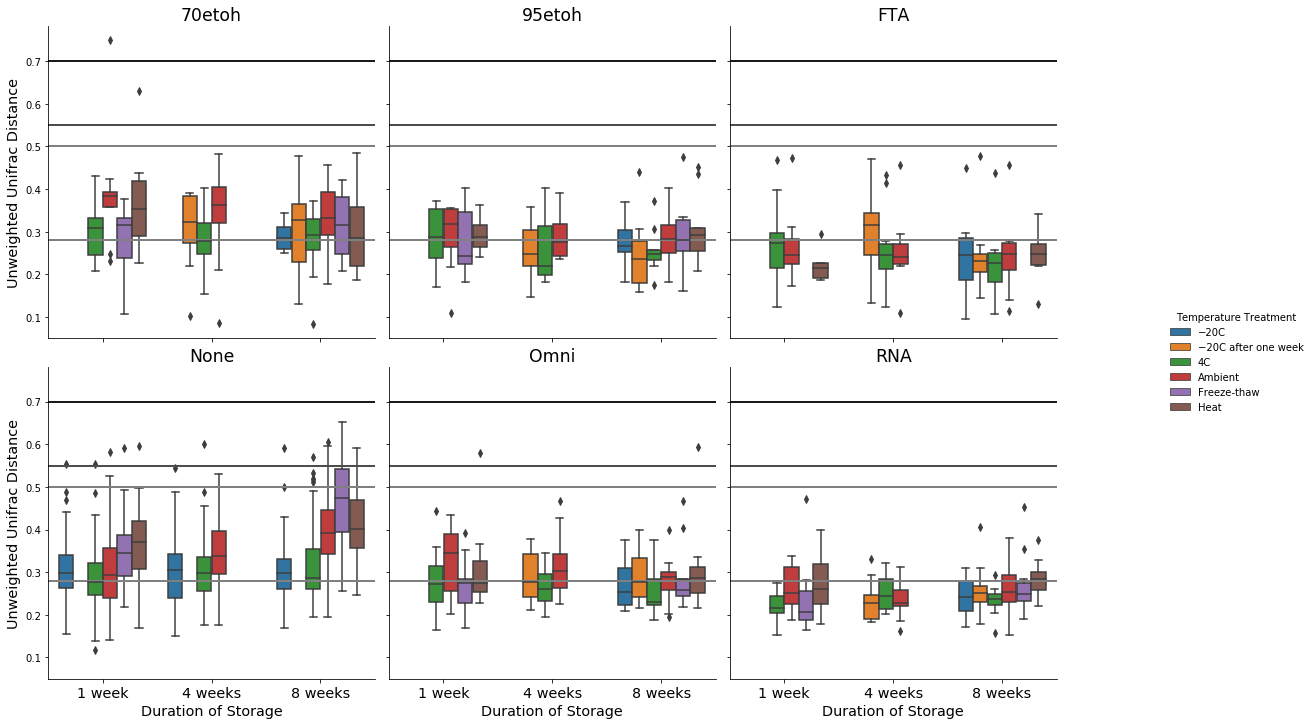

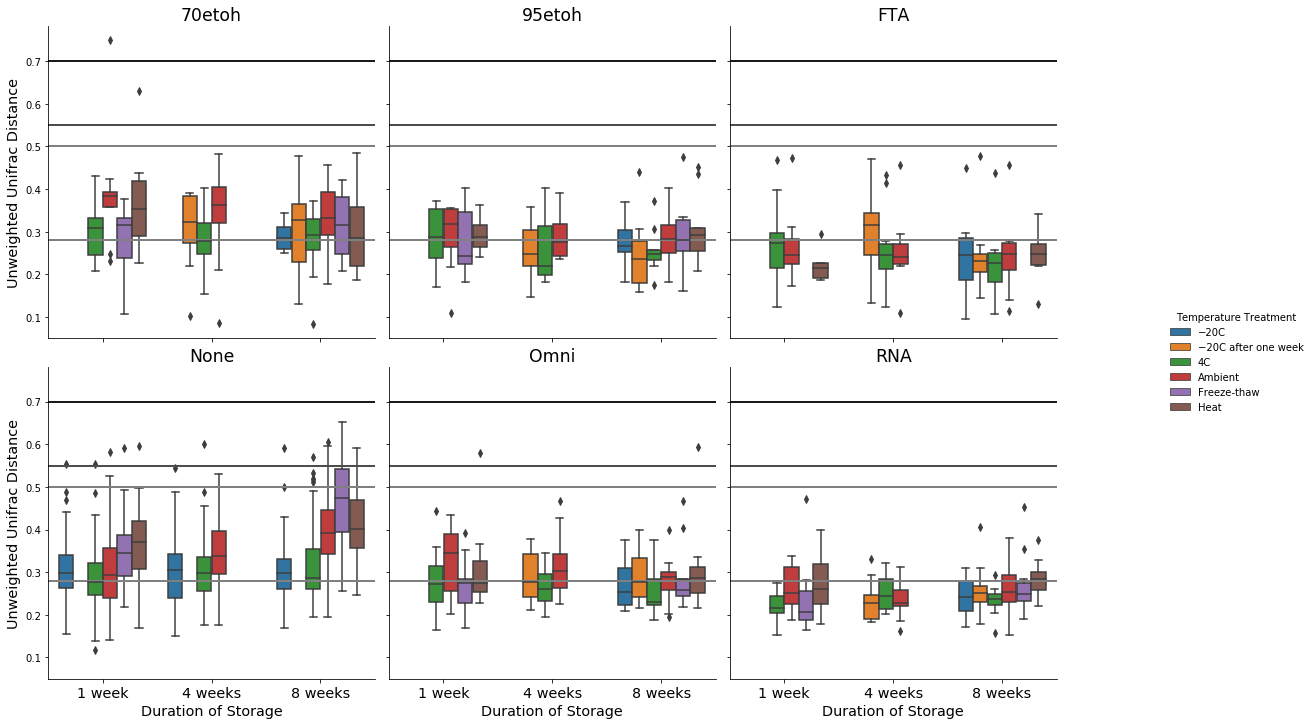

In [10]:
fancy_plotting(between_distances1).savefig("unweighted-fresh-bl.png")
fancy_plotting(between_distances1).savefig('UnUF-distance-figure-fresh-amb-bl.svg', format='svg', dpi=1200)

In [14]:
def fancy_plotting2(df):
    g = sns.catplot(data=df, x='duration_of_storage', y='value', 
                    hue='sample_storage_temp_treatment_week_added', col='sample_preservation_method',
                    kind='box', col_wrap=3,
                    #palette=sns.color_palette("RdBu_r", 7)
                    order=['fresh','1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Duration of Storage", "Unweighted Unifrac Distance")
    g.set_xticklabels(["Fresh", "1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
    g._legend.set_title("Temperature Treatment")
    
    new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
        ax.axhline(0.7, ls='-', color='0.1', linewidth=2) #inter-species
        ax.axhline(0.55, ls='-', color='0.3', linewidth=2) #inter-human
        ax.axhline(0.5, ls='-', color='0.5', linewidth=2) #inter-dog
        
        ax.axhline(0.28, ls='-', color='0.5', linewidth=2) #inter-replicate
        
    return g

In [15]:
between_distances2 = gather_between_distances(original_dm, md, False)

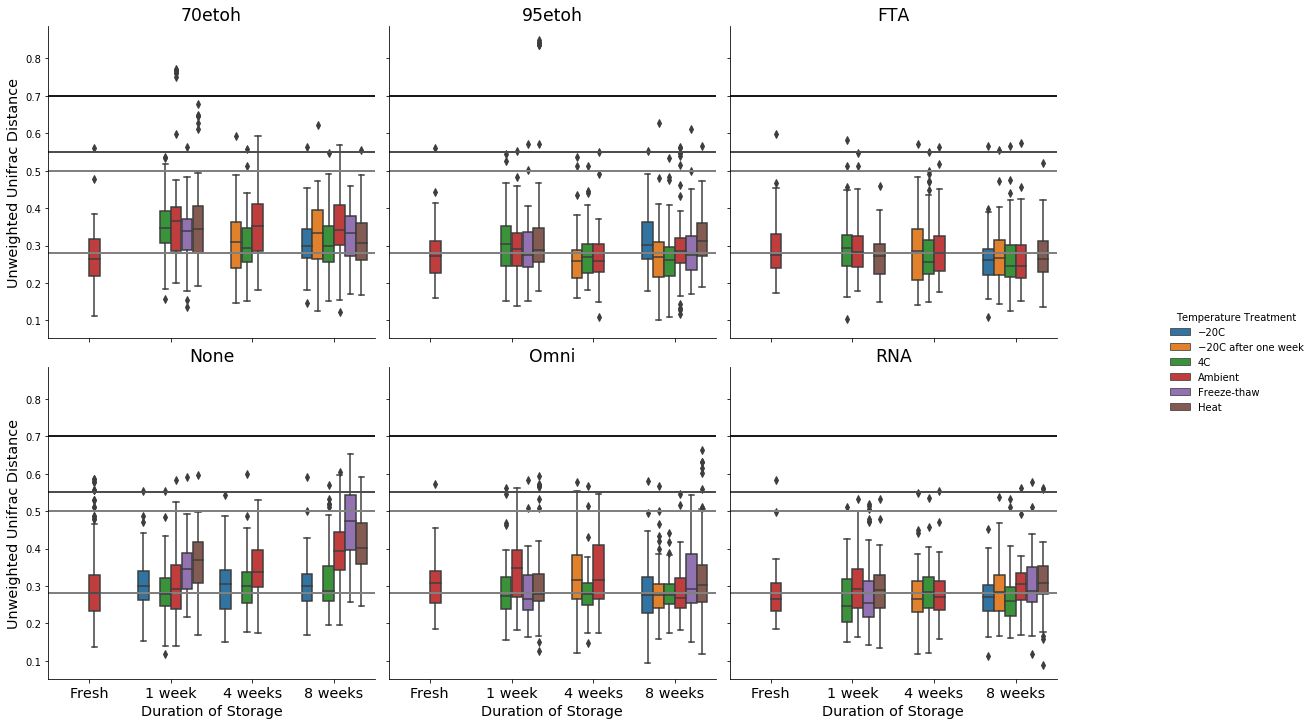

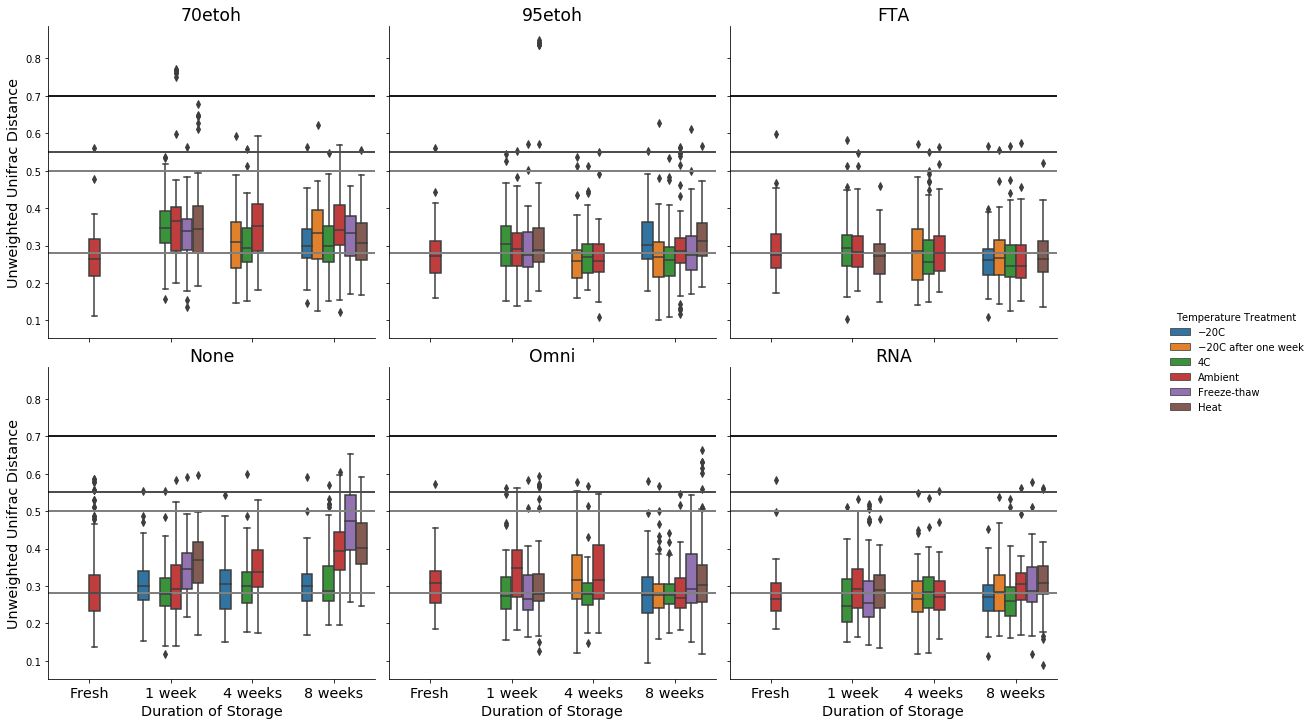

In [16]:
fancy_plotting2(between_distances2).savefig("unweighted-none-fresh-amb-bl.png")
fancy_plotting2(between_distances2).savefig('UnUF-distance-figure-none-fresh-amb-bl.svg', format='svg', dpi=1200)